In [6]:
import fitsio
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt

from base64 import b64encode
import mechanize

%matplotlib inline

# I'm using Pandas (based on numpy), which is a very useful tool for
# handling tables and data.
# I'll properly put them into classes or more organized later

In [7]:
#12GB file, be carefull
file_name = 'spAll-v5_10_0.fits'

fits = fitsio.FITS(file_name) 

# Columns we are interested on
cols = ['CLASS', 'RA','DEC','THING_ID','OBJTYPE','MJD','PLATE','FIBERID','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1']

In [8]:
# to show all names in file
#fits[1]

In [9]:
#%%time

# Reading columns
#http://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
#d = {col: fits[1][col].read().byteswap().newbyteorder() for col in cols}

In [10]:
df = pd.DataFrame(d)
print 'number of rows =', len(df)
df.head()

NameError: name 'd' is not defined

In [11]:
%%time
#df.to_csv('subset_spAll-v5_10_0.csv', index=False)
df = pd.read_csv('subset_spAll-v5_10_0.csv')

CPU times: user 3.78 s, sys: 479 ms, total: 4.26 s
Wall time: 4.48 s


In [12]:
print 'number of rows =', len(df)
df.head()

number of rows = 3008000


,BOSS_TARGET1,CLASS,DEC,EBOSS_TARGET0,EBOSS_TARGET1,FIBERID,MJD,OBJTYPE,PLATE,RA,THING_ID
0,0,GALAXY,26.188042,0,2,1,57346,GALAXY,10000,30.012094,339167825
1,0,QSO,26.582945,0,1024,2,57346,QSO,10000,31.282286,342410358
2,0,GALAXY,26.608501,0,2,3,57346,GALAXY,10000,31.279594,342410449
3,0,QSO,26.682522,0,2048,4,57346,QSO,10000,31.237546,342675982
4,0,STAR,26.866054,0,2,5,57346,GALAXY,10000,31.394521,344112497


## Computing pixels

In [13]:
'''map celestial coordinates to angular'''

#The resolution of the map
NSide = 2**5

phi_rad   = lambda ra : ra*np.pi/180.
theta_rad = lambda dec: (90.0 - dec)*np.pi/180.

df['PIX'] = hp.ang2pix(NSide, theta_rad(df['DEC']), phi_rad(df['RA']))

# Number of unique pixels
len(df['PIX'].unique())

3369

In [14]:
df = df.query('CLASS== "QSO".ljust(6) & (OBJTYPE=="QSO".ljust(16) | OBJTYPE=="NA".ljust(16)) & THING_ID != -1')
df.head()

,BOSS_TARGET1,CLASS,DEC,EBOSS_TARGET0,EBOSS_TARGET1,FIBERID,MJD,OBJTYPE,PLATE,RA,THING_ID,PIX
1,0,QSO,26.582945,0,1024,2,57346,QSO,10000,31.282286,342410358,3403
3,0,QSO,26.682522,0,2048,4,57346,QSO,10000,31.237546,342675982,3403
5,0,QSO,26.810259,0,1024,6,57346,QSO,10000,31.327011,344111998,3403
6,0,QSO,26.935936,0,2048,7,57346,QSO,10000,31.408747,345724597,3275
7,0,QSO,26.953807,0,1024,8,57346,QSO,10000,31.362048,345724589,3275


## Searching for quasars

In [15]:
bit_boss = [10,11,12,13,14,15,16,17,18,19,40,41,42,43,44]
bit_eboss = [10,11,12,13,14,15,16,17,18]

def is_quasar(dataset, mask_bit):
    is_qso  = lambda b: ((df[dataset] & 2**b) > 0)
    all_qso = map(is_qso, mask_bit)
    return reduce(lambda x, y: x |  y , all_qso)

In [16]:
print 'total qso in BOSS_TARGET1 =  ', is_quasar('BOSS_TARGET1', bit_boss).sum()
print 'total qso in EBOSS_TARGET0 = ', is_quasar('EBOSS_TARGET0', bit_eboss).sum()
print 'total qso in EBOSS_TARGET1 = ', is_quasar('EBOSS_TARGET1', bit_eboss).sum() 

total qso in BOSS_TARGET1 =   285071
total qso in EBOSS_TARGET0 =  38164
total qso in EBOSS_TARGET1 =  160854


In [17]:
#Filter only quasars

only_qso = df[ is_quasar('BOSS_TARGET1', bit_boss)   |
                 is_quasar('EBOSS_TARGET0', bit_eboss) | 
                 is_quasar('EBOSS_TARGET1', bit_eboss)]
boss_qso = df[ is_quasar('BOSS_TARGET1', bit_boss)]

print 'all_qsos=', len(only_qso) 
print 'boss_qsos=', len(boss_qso) 

all_qsos= 484089
boss_qsos= 285071


In [18]:
#test to generalize
#dict_try = {'BOSS_TARGET1':bit_boss, 'EBOSS_TARGET0': bit_eboss, 'EBOSS_TARGET1': bit_eboss}
#a = []
#for k, v in dict_try.iteritems():
#     a.append(is_quasar(k, v))
##len(only_qso)
#print len(df[reduce(lambda x, y: x |  y , a)])

## indexing and sorting by index


In [19]:
#Eliminate quasars that have THING_ID == -1

all_qso = only_qso.set_index(['PIX','THING_ID'], drop=False).sort_index()
all_qso.head()

BOSS_TARGET1   CLASS        DEC  EBOSS_TARGET0  EBOSS_TARGET1  \
PIX THING_ID                                                                    
391 552894319  2199023796224  QSO     68.381197              0              0   
    552921545  2199023796224  QSO     68.418125              0              0   
392 552514273  3298535424000  QSO     68.011275              0              0   
    552514407  3298535424000  QSO     68.070896              0              0   
    552727940  3298535424000  QSO     68.328449              0              0   

               FIBERID    MJD           OBJTYPE  PLATE          RA   THING_ID  \
PIX THING_ID                                                                    
391 552894319      622  56667  QSO                7115  175.258222  552894319   
    552921545      624  56667  QSO                7115  175.582630  552921545   
392 552514273      932  56748  QSO                6966  185.714425  552514273   
    552514407      886  56748  QSO                6966  185.578268  552514407   
    552727940      918  56748  QSO                6966  185.944277  552727940   

               PIX  
PIX THING_ID        
391 552894319  391  
    552921545  391  
392 552514273  392  
    552514407  392  
    552727940  392

In [20]:
print (len(all_qso))

484089


In [21]:
group_dt= all_qso.groupby('THING_ID').size().to_frame('rep')

### Qsos which THING_ID is repeated >= 2

In [22]:
print (len(all_qso)) - len(group_dt[group_dt['rep']==1])

93966


### Select  a certain pixel info

In [23]:
#only the first rows of pixel 393
all_qso.query('PIX == 450 | PIX == 796').head()

BOSS_TARGET1   CLASS        DEC  EBOSS_TARGET0  EBOSS_TARGET1  \
PIX THING_ID                                                                    
450 550116719  2199023255552  QSO     66.581635              0              0   
    550164118  2199023796224  QSO     66.543038              0              0   
    550164118  2199023796224  QSO     66.543038              0              0   
    550532243  2199023779840  QSO     66.691725              0              0   
    550532243  2199023779840  QSO     66.691725              0              0   

               FIBERID    MJD           OBJTYPE  PLATE          RA   THING_ID  \
PIX THING_ID                                                                    
450 550116719      914  56720  QSO                6975  185.252205  550116719   
    550164118       86  56748  QSO                6966  185.340753  550164118   
    550164118      493  56720  QSO                7120  185.340753  550164118   
    550532243      132  56748  QSO                6966  185.091304  550532243   
    550532243      905  56720  QSO                6975  185.091304  550532243   

               PIX  
PIX THING_ID        
450 550116719  450  
    550164118  450  
    550164118  450  
    550532243  450  
    550532243  450

In [24]:
print '# of THING_IDs within this pixel =', len(all_qso.loc[392].index)
print '# of unique THING_IDs within this pixel =', len(all_qso.loc[392].index.unique())

# of THING_IDs within this pixel = 10
# of unique THING_IDs within this pixel = 10


In [25]:
#print pixel, thing_id and number of times repeated
def pix_with_uniqueid(pix_id, max_rep):
    rep_thing_id = all_qso.query('PIX == {}'.format(pix_id)).groupby('THING_ID').size()
    if not rep_thing_id[rep_thing_id> max_rep].empty:
        print pix_id, dict(rep_thing_id[rep_thing_id> max_rep])
    

In [26]:
list_pix = all_qso['PIX'].unique()

In [27]:
#{pix: {thing_id: n_repetitions}}
for a in list_pix[:200]:
    pix_with_uniqueid(a, 4)

1051 {505037851: 5}


In [28]:

def get_file(plate, name_of_file):
    url = 'https://data.sdss.org/sas/ebosswork/eboss/spectro/redux/v5_10_0/spectra/%s/%s'%(plate,name_of_file)
    username = 'sdss'
    password = '2.5-meters'

    # I have had to add a carriage return ('%s:%s\n'), but
    # you may not have to.
    b64login = b64encode('%s:%s' % (username, password))

    br = mechanize.Browser()
    br.set_handle_robots(False)
    
    br.addheaders.append( 
      ('Authorization', 'Basic %s' % b64login )
    )

    br.open(url)
    r = br.response()
    data = r.read()

    with open('%s'%(name_of_file),'wb') as output:
          output.write(data)

## Quasars with same THING_ID

In [30]:
thing_id = 110619413 #341840093 
all_qso.query('THING_ID == %s'%(thing_id))

BOSS_TARGET1   CLASS       DEC  EBOSS_TARGET0  EBOSS_TARGET1  \
PIX  THING_ID                                                                   
6093 110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413         246784  QSO     0.800487              0              0   
     110619413  2199023259648  QSO     0.800487              0              0   

                FIBERID    MJD           OBJTYPE  PLATE         RA   THING_ID  \
PIX  THING_ID                                                                   
6093 110619413      946  55179  QSO                3615  38.248336  110619413   
     110619413      948  55208  QSO                3615  38.248336  110619413   
     110619413      964  56219  QSO                3615  38.248336  110619413   
     110619413      952  56544  QSO                3615  38.248336  110619413   
     110619413      957  55181  QSO                3647  38.248336  110619413   
     110619413      949  55241  QSO                3647  38.248336  110619413   
     110619413      953  55476  QSO                3647  38.248336  110619413   
     110619413      967  55827  QSO                3647  38.248336  110619413   
     110619413      999  55945  QSO                3647  38.248336  110619413   
     110619413      947  56219  QSO                3647  38.248336  110619413   
     110619413      941  56568  QSO                3647  38.248336  110619413   
     110619413      945  56596  QSO                3647  38.248336  110619413   
     110619413      948  55455  QSO                4238  38.248336  110619413   

                 PIX  
PIX  THING_ID         
6093 110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093  
     110619413  6093

In [805]:
plates   = list(all_qso.query('THING_ID == %s'%(thing_id))['PLATE'].values)
mjds     = list(all_qso.query('THING_ID == %s'%(thing_id))['MJD'].values)
fiberids = list(all_qso.query('THING_ID == %s'%(thing_id))['FIBERID'].values)

In [806]:
files = ['spec-%s-%s-%s.fits'%(plate,mjd,str(fiberid).zfill(4)) for plate,mjd,fiberid in zip(plates,mjds,fiberids)]
plate_n = ['%s'%(plate) for plate in plates]

In [629]:
#get files from the web and store them into your current directory
#for plate, names in zip(plates, files):
#    get_file(plate, names)

In [38]:
#read fits files 

def read_flux_file(files):
    fits = fitsio.FITS(files)
    cols = ['flux','loglam','ivar','and_mask','or_mask', 'wdisp', 'sky', 'model']
    d = {col: fits[1][col].read().byteswap().newbyteorder() for col in cols}
    df = pd.DataFrame(d)
    return df

In [809]:
dt_s=[]
for l in files:
        dt_x = read_flux_file(l).set_index('loglam')
        dt_s.append(dt_x)

In [810]:
# Masking
mask=[]
for s in dt_s:
    mask.append(s.query('and_mask==0').copy())
mask[1].head()

,and_mask,flux,ivar,model,or_mask,sky,wdisp
loglam,,,,,,,
3.5532,0,-5.167075,0.026013,1.150802,71303168,5.765884,1.425145
3.5533,0,1.226554,0.039627,1.144034,71303168,5.071245,1.351668
3.5534,0,0.927009,0.040588,1.140665,71303168,4.487135,1.351275
3.5535,0,2.266115,0.040700,1.115641,71303168,4.087581,1.344525
3.5536,0,4.675598,0.044205,1.073475,71303168,3.658009,1.350873


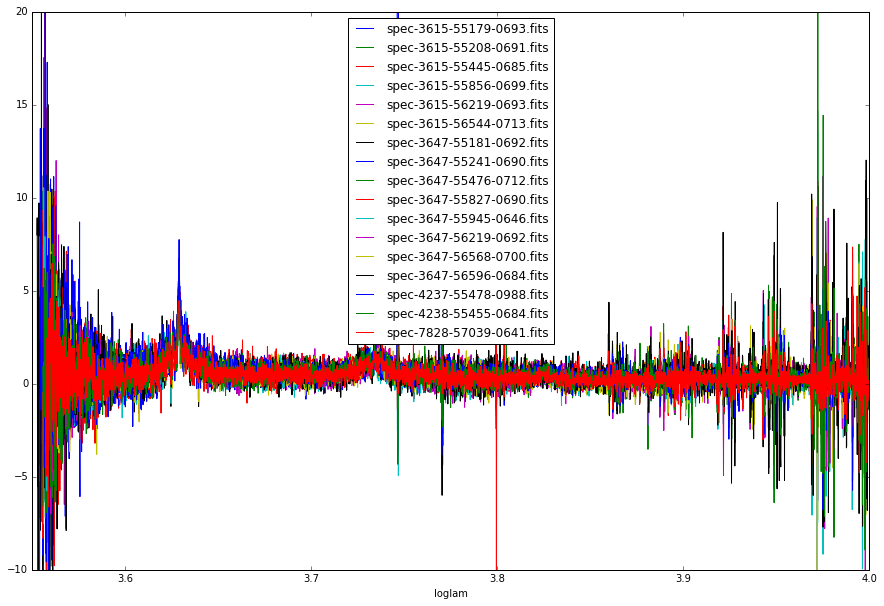

In [811]:
fig = plt.figure(figsize = (15, 10))
xlimits = [3.55,4]
ylimits = [-10,20]
for i in range(len(files)):
    dt_s[i]['flux'].plot(label=files[i],xlim=xlimits, ylim=ylimits) 
plt.legend(loc='best')

In [812]:
#check for the xrange and the size of the step

#print [len(mask[i]) for i in range(5)]
#for i in range(5):
#    print (mask[i].index.values.min()- mask[i].index.values.max())/len(mask[i])
#for i in range(len(files)):
#    x=dt_s[i].index.values
    #print(len(x))
    #print (x[-1]-x[0])/(len(x)-1)

In [813]:
#plot for the masks

#fig = plt.figure(figsize = (15, 10))
#ax= plt.subplot(1,1,1)
##dt_s
#mask[0][['flux','model', 'ivar']].plot(ax=ax)
#mask[1][['flux','model', 'ivar']].plot(ax=ax)

In [814]:
#read coefficients

#fits = fitsio.FITS(files[0])
#coeff0, coeff1 = fits[0].read_header()['COEFF0'], fits[0].read_header()['COEFF1']
#for f in files:
#    fits = fitsio.FITS(f)
#    print fits[0].read_header()['COEFF0'], fits[0].read_header()['COEFF1']

#for i in range(len(files)):
#    x=dt_s[i].index.values
#    print (x[-1]-x[0])/(len(x)-1), len(x)

In [815]:
for i in range(len(files)):
        dt_s[i]['flux_%s'%(i)] = dt_s[i]['flux']
        dt_s[i]['ivar_%s'%(i)] = dt_s[i]['ivar']

In [816]:
x =range(len(files))
result = pd.concat([dt_s[i][['flux_%s'%(i),'ivar_%s'%(i)]] for i in x], axis=1)
all_qsos= result.fillna(0).copy()
all_qsos.head()

,flux_0,ivar_0,flux_1,ivar_1,flux_2,ivar_2,flux_3,ivar_3,flux_4,ivar_4,...,flux_12,ivar_12,flux_13,ivar_13,flux_14,ivar_14,flux_15,ivar_15,flux_16,ivar_16
loglam,,,,,,,,,,,,,,,,,,,,,
3.5525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.5526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.5527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.5528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.5529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [817]:
all_qsos['sum_flux_ivar']=0
all_qsos['sum_ivar']=0
for i in x:
    all_qsos['sum_flux_ivar'] += all_qsos['flux_%s'%(i)]*all_qsos['ivar_%s'%(i)]
    all_qsos['sum_ivar']      += all_qsos['ivar_%s'%(i)] 
all_qsos['coadd'] = all_qsos['sum_flux_ivar']/all_qsos['sum_ivar']

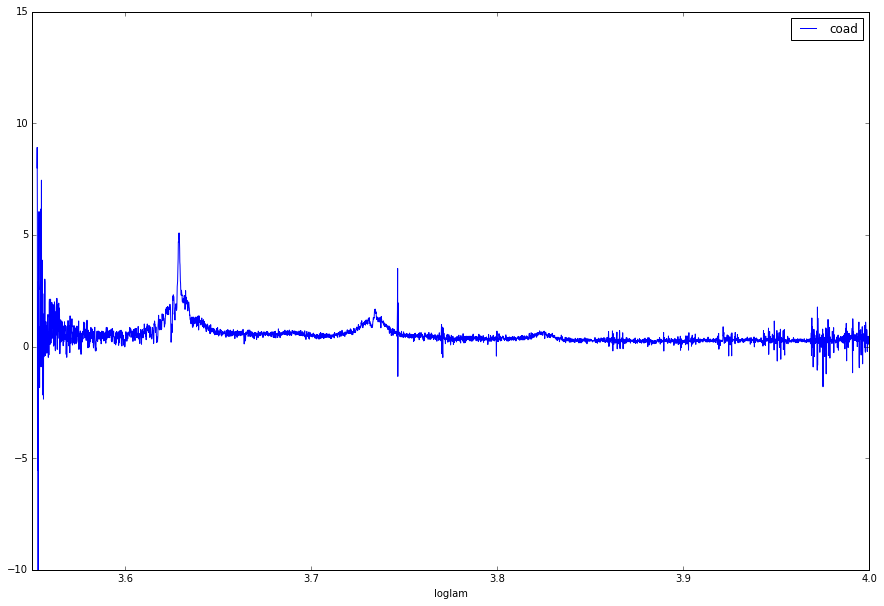

In [818]:
fig = plt.figure(figsize = (15, 10))
ax= plt.subplot(1,1,1)
xlimits = [3.55,4]
ylimits = [-10,15]
all_qsos['coadd'].plot(ax=ax, label='coad', xlim=xlimits, ylim=ylimits)
plt.legend(loc='best')

In [819]:
all_qsos = all_qsos.fillna(0).copy()
all_qsos['coadd'].values

array([  8.00602631,   8.92329408,   6.29712816, ...,  -1.62233003,
        -7.45756262, -21.88217937])

In [820]:
for i in x:
    chi_squared = np.sum((all_qsos['coadd'].values - all_qsos['flux_%s'%(i)].values)**2*all_qsos['ivar_%s'%(i)].values)
    print  'chi-sq=',chi_squared/len(all_qsos.values), '\t\t', files[i]

chi-sq= 1.18316693261 		spec-3615-55179-0693.fits
chi-sq= 0.814630036411 		spec-3615-55208-0691.fits
chi-sq= 0.950363933276 		spec-3615-55445-0685.fits
chi-sq= 1.02254375672 		spec-3615-55856-0699.fits
chi-sq= 0.862993206424 		spec-3615-56219-0693.fits
chi-sq= 0.974970030558 		spec-3615-56544-0713.fits
chi-sq= 1.0354952373 		spec-3647-55181-0692.fits
chi-sq= 1.39189271561 		spec-3647-55241-0690.fits
chi-sq= 0.926219350812 		spec-3647-55476-0712.fits
chi-sq= 0.935085283558 		spec-3647-55827-0690.fits
chi-sq= 0.979185019436 		spec-3647-55945-0646.fits
chi-sq= 0.864700491685 		spec-3647-56219-0692.fits
chi-sq= 1.0134173737 		spec-3647-56568-0700.fits
chi-sq= 0.948529755146 		spec-3647-56596-0684.fits
chi-sq= 1.16203634253 		spec-4237-55478-0988.fits
chi-sq= 0.854323898489 		spec-4238-55455-0684.fits
chi-sq= 0.979416702791 		spec-7828-57039-0641.fits


In [642]:
all_qsos.head()

,flux_0,ivar_0,flux_1,ivar_1,flux_2,ivar_2,flux_3,ivar_3,flux_4,ivar_4,...,ivar_13,flux_14,ivar_14,flux_15,ivar_15,flux_16,ivar_16,sum_flux_ivar,sum_ivar,coadd
loglam,,,,,,,,,,,,,,,,,,,,,
3.5525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070327,0.008784,8.006026
3.5526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077585,0.008695,8.923294
3.5527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059792,0.009495,6.297128
3.5528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.061222,0.011081,-5.524771
3.5529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.061483,0.011337,-5.423411


In [836]:
vect ={'spec-10000-57346-0092.fits': 2.2829750574821879, 'spec-6270-56273-0202.fits': 4.758888651905119, 'spec-7691-57360-0094.fits': 1.388886219480967, 'spec-7691-57040-0100.fits': 1.0508165679437143, 'spec-5697-55944-0990.fits': 0.998865915125282}


In [837]:
vect

{'spec-10000-57346-0092.fits': 2.282975057482188,
 'spec-5697-55944-0990.fits': 0.998865915125282,
 'spec-6270-56273-0202.fits': 4.758888651905119,
 'spec-7691-57040-0100.fits': 1.0508165679437143,
 'spec-7691-57360-0094.fits': 1.388886219480967}

In [840]:
rm_file =[]
for files, chisq in vect.iteritems():
    if chisq > 4:
        rm_file.append(files)

In [842]:
for rm in rm_file:
    del vect[rm]

In [850]:
vect

{'spec-10000-57346-0092.fits': 2.282975057482188,
 'spec-5697-55944-0990.fits': 0.998865915125282,
 'spec-7691-57040-0100.fits': 1.0508165679437143,
 'spec-7691-57360-0094.fits': 1.388886219480967}

In [851]:
t ='spec-10000-57346-0436.fits'

In [857]:
t.replace('spec-','')

'10000-57346-0436.fits'

In [858]:
t

'spec-10000-57346-0436.fits'

In [ ]:
0093